In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/india-rental-house-price/Indian_housing_Mumbai_data.csv
/kaggle/input/india-rental-house-price/Indian_housing_Pune_data.csv
/kaggle/input/india-rental-house-price/Indian_housing_Delhi_data.csv


# Project. Data Analysis and Modeling¶
## Goal
> ### EDA : Analysis of trends
> ### Modeling : Predict the House price

# Import Libraries & Read Dataset

In [2]:
# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from datetime import datetime, timedelta
import re
import seaborn as sns
import warnings
import random
import os
from collections import OrderedDict
warnings.filterwarnings("ignore")

# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
file_name_Mumbai = '/kaggle/input/india-rental-house-price/Indian_housing_Mumbai_data.csv'
file_name_Pune = '/kaggle/input/india-rental-house-price/Indian_housing_Pune_data.csv'
file_name_Delhi = '/kaggle/input/india-rental-house-price/Indian_housing_Delhi_data.csv'

data_Mumbai = pd.read_csv(file_name_Mumbai)
data_Pune = pd.read_csv(file_name_Pune)
data_Delhi = pd.read_csv(file_name_Delhi)

data_all = [data_Mumbai, data_Pune, data_Delhi]

data = pd.concat(data_all, ignore_index=True)

In [4]:
for df in data_all:
    df.info()
    print('\n\n')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   house_type        5000 non-null   object 
 1   house_size        5000 non-null   object 
 2   location          5000 non-null   object 
 3   city              5000 non-null   object 
 4   latitude          5000 non-null   float64
 5   longitude         5000 non-null   float64
 6   price             5000 non-null   int64  
 7   currency          5000 non-null   object 
 8   numBathrooms      4986 non-null   float64
 9   numBalconies      733 non-null    float64
 10  isNegotiable      571 non-null    object 
 11  priceSqFt         0 non-null      float64
 12  verificationDate  5000 non-null   object 
 13  description       4922 non-null   object 
 14  SecurityDeposit   5000 non-null   object 
 15  Status            5000 non-null   object 
dtypes: float64(5), int64(1), object(10)
memory

In [5]:
round(data.describe(),2)

,latitude,longitude,price,numBathrooms,numBalconies,priceSqFt
count,13910.00,13910.00,13910.00,13854.00,5291.00,0.0
mean,22.38,74.71,108497.13,2.33,1.84,NaN
std,4.66,2.18,193434.88,1.00,0.70,NaN
min,17.47,18.50,1500.00,1.00,1.00,NaN
25%,18.61,72.97,18000.00,2.00,1.00,NaN
50%,19.15,73.90,33000.00,2.00,2.00,NaN
75%,28.55,77.15,90000.00,3.00,2.00,NaN
max,31.11,91.79,3010101.00,10.00,8.00,NaN


In [6]:
data.isna().mean()

house_type          0.000000
house_size          0.000000
location            0.000000
city                0.000000
latitude            0.000000
longitude           0.000000
price               0.000000
currency            0.000000
numBathrooms        0.004026
numBalconies        0.619626
isNegotiable        0.908267
priceSqFt           1.000000
verificationDate    0.000000
description         0.059741
SecurityDeposit     0.000000
Status              0.000000
dtype: float64

# Data Preprocessing 

> # Dealing with missing values

In [7]:
missing_value = pd.DataFrame(data.isna().mean(), columns=['percentage'])
missing_value = missing_value[missing_value['percentage'] >= 0.5]
round(missing_value,2)

,percentage
numBalconies,0.62
isNegotiable,0.91
priceSqFt,1.00


In [8]:
idx = missing_value.index

for i in idx:
    print(i,"\'s kinds :",data[i].unique())

numBalconies 's kinds : [nan  2.  4.  1.  5.  6.  3.  8.]
isNegotiable 's kinds : [nan 'Negotiable']
priceSqFt 's kinds : [nan]


In [9]:
data_for_EDA = data_for_model = data
data_for_EDA[idx] = data_for_EDA[idx].fillna(0)
data_for_EDA = data_for_EDA.drop('priceSqFt', axis=1)

In [10]:
data_for_EDA = data_for_EDA.dropna()
data_for_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13024 entries, 0 to 13909
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   house_type        13024 non-null  object 
 1   house_size        13024 non-null  object 
 2   location          13024 non-null  object 
 3   city              13024 non-null  object 
 4   latitude          13024 non-null  float64
 5   longitude         13024 non-null  float64
 6   price             13024 non-null  int64  
 7   currency          13024 non-null  object 
 8   numBathrooms      13024 non-null  float64
 9   numBalconies      13024 non-null  float64
 10  isNegotiable      13024 non-null  object 
 11  verificationDate  13024 non-null  object 
 12  description       13024 non-null  object 
 13  SecurityDeposit   13024 non-null  object 
 14  Status            13024 non-null  object 
dtypes: float64(4), int64(1), object(10)
memory usage: 1.6+ MB


> # Feature Engineering for EDA

In [11]:
data_for_EDA['house_type'].unique()

array(['2 BHK Apartment ', '3 BHK Apartment ', '1 RK Studio Apartment ',
       '1 BHK Apartment ', '4 BHK Apartment ', '1 BHK Independent Floor ',
       '3 BHK Villa ', '3 BHK Independent House ',
       '4 BHK Independent House ', '4 BHK Villa ', '6 BHK Apartment ',
       '2 BHK Independent House ', '5 BHK Apartment ', '1 BHK Villa ',
       '4 BHK Independent Floor ', '6 BHK Villa ', '5 BHK Villa ',
       '3 BHK Independent Floor ', '2 BHK Independent Floor ',
       '6 BHK penthouse ', '1 BHK Independent House ',
       '5 BHK Independent House ', '2 BHK Villa ',
       '6 BHK Independent House ', '8 BHK Independent Floor ',
       '6 BHK Independent Floor ', '5 BHK Independent Floor ',
       '7 BHK Independent Floor ', '8 BHK Independent House ',
       '10 BHK Independent House ', '7 BHK Independent House ',
       '9 BHK Independent House ', '8 BHK Villa ',
       '12 BHK Independent House '], dtype=object)

In [12]:
def normalize_house_type(house_type):
    if 'penthouse' in house_type:
        return 'Penthouse'
    elif 'Studio Apartment' in house_type:
        return 'Studio Apartment'
    elif 'Villa' in house_type:
        return 'Villa'
    elif 'Independent Floor' in house_type:
        return 'Independent Floor'
    elif 'Independent House' in house_type:
        return 'Independent House'
    else:
        return 'Other'

data_for_EDA['normalize_house_type'] = data_for_EDA['house_type'].apply(normalize_house_type)
print(data_for_EDA['normalize_house_type'].unique())

['Other' 'Studio Apartment' 'Independent Floor' 'Villa'
 'Independent House' 'Penthouse']


In [13]:
data_for_EDA['house_size'].unique()

array(['1,180 sq ft', '1,120 sq ft', '1,200 sq ft', ..., '6,321 sq ft',
       '333 sq ft', '1,855 sq ft'], dtype=object)

In [14]:
data_for_EDA['house_size_1000'] = (data_for_EDA['house_size'].str.replace(' sq ft', '').str.replace(',', '').astype(int) // 1000) * 1000
house_size_price_mean = data_for_EDA.groupby('house_size_1000')['price'].mean()
print(data_for_EDA['house_size_1000'].unique())

[ 1000     0  2000  3000  4000  8000  6000  5000  7000  9000 10000 14000]


In [15]:
data_for_EDA['verificationDate'].unique()

array(['Posted 2 years ago', 'Posted a month ago', 'Posted 3 years ago',
       'Posted 3 months ago', 'Posted 2 months ago', 'Posted 23 days ago',
       'Posted 18 days ago', 'Posted 11 days ago', 'Posted 4 days ago',
       'Posted a day ago', 'Posted 17 days ago', 'Posted 4 months ago',
       'Posted 12 days ago', 'Posted 8 months ago', 'Posted a year ago',
       'Posted 13 days ago', 'Posted 16 days ago', 'Posted 20 days ago',
       'Posted 19 days ago', 'Posted 22 days ago', 'Posted 9 days ago',
       'Posted 15 days ago', 'Posted 21 days ago', 'Posted 14 days ago',
       'Posted 5 days ago', 'Posted 10 days ago', 'Posted 20 hours ago',
       'Posted 8 days ago', 'Posted 2 days ago', 'Posted 24 days ago',
       'Posted 3 days ago', 'Posted 25 days ago', 'Posted 7 days ago',
       'Posted 6 days ago', 'Posted 17 hours ago', 'Posted 5 months ago',
       'Posted 19 hours ago', 'Posted 16 hours ago',
       'Posted 10 hours ago', 'Posted 21 hours ago',
       'Posted 11 hour

In [16]:
def normalize_date_type(date_str):
    if 'year' in date_str or 'years' in date_str:
        return 'year'
    elif 'month' in date_str or 'months' in date_str:
        return 'month'
    elif 'day' in date_str or 'days' in date_str:
        return 'day'
    elif 'hour' in date_str or 'hours' in date_str:
        return 'hour'
    elif 'minute' in date_str or 'minutes' in date_str:
        return 'minute'
    else:
        return 'Other'

data_for_EDA['date_type'] = data_for_EDA['verificationDate'].apply(normalize_date_type)
data_for_EDA['date_type'].unique()

array(['year', 'month', 'day', 'hour', 'minute'], dtype=object)

> # Feature Engineering for model

In [17]:
data_for_model = data_for_EDA
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13024 entries, 0 to 13909
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   house_type            13024 non-null  object 
 1   house_size            13024 non-null  object 
 2   location              13024 non-null  object 
 3   city                  13024 non-null  object 
 4   latitude              13024 non-null  float64
 5   longitude             13024 non-null  float64
 6   price                 13024 non-null  int64  
 7   currency              13024 non-null  object 
 8   numBathrooms          13024 non-null  float64
 9   numBalconies          13024 non-null  float64
 10  isNegotiable          13024 non-null  object 
 11  verificationDate      13024 non-null  object 
 12  description           13024 non-null  object 
 13  SecurityDeposit       13024 non-null  object 
 14  Status                13024 non-null  object 
 15  normalize_house_type  13

In [18]:
data_for_model.head()

,house_type,house_size,location,city,latitude,longitude,price,currency,numBathrooms,numBalconies,isNegotiable,verificationDate,description,SecurityDeposit,Status,normalize_house_type,house_size_1000,date_type
0,2 BHK Apartment,"1,180 sq ft",Ulwe,Mumbai,18.971046,73.017723,19000,INR,2.0,0.0,0,Posted 2 years ago,It has area of 1180 sqft and is available at a...,No Deposit,Furnished,Other,1000,year
1,2 BHK Apartment,"1,120 sq ft",Ulwe,Mumbai,18.966377,73.012802,12500,INR,2.0,0.0,0,Posted 2 years ago,Well designed 2 bhk multistorey apartment is a...,No Deposit,Unfurnished,Other,1000,year
2,2 BHK Apartment,"1,200 sq ft",Panvel,Mumbai,18.965979,73.124649,22000,INR,2.0,0.0,0,Posted a month ago,A spacious 2 bhk multistorey apartment is avai...,No Deposit,Unfurnished,Other,1000,month
3,2 BHK Apartment,750 sq ft,Kandivali West,Mumbai,19.213598,72.833633,28500,INR,2.0,0.0,0,Posted 3 years ago,It has a built-up area of 750 sqft and is avai...,No Deposit,Unfurnished,Other,0,year
4,3 BHK Apartment,"1,400 sq ft",Chembur,Mumbai,19.062933,72.892395,50000,INR,3.0,0.0,0,Posted 3 years ago,The house is semi-furnished. It has power back...,No Deposit,Semi-Furnished,Other,1000,year


### Remove columns with overlapping meanings and unnecessary columns, and make the rest dummy variables.

In [19]:
data_for_model['SecurityDeposit'] = data_for_model['SecurityDeposit'].str.replace(',', '').replace('No Deposit', '0').astype(int)
data_for_model['house_size'] = data_for_model['house_size'].astype(str).str.replace('sq ft', '').str.replace(',', '').astype(int)

In [20]:
data_for_model = data_for_model.drop(['verificationDate','description','house_type','house_size_1000'], axis=1)
categorical_dummies = pd.get_dummies(data_for_model.select_dtypes(include=['object']))
numerical_columns = data_for_model.select_dtypes(exclude=['object'])
data_for_model = pd.concat([categorical_dummies, numerical_columns], axis=1)

> ## Compare

In [21]:
print('Data shape : ',data.shape)
print('Data_EDA shape : ',data_for_EDA.shape)
print('Data_model shape : ',data_for_model.shape)

Data shape :  (13910, 16)
Data_EDA shape :  (13024, 18)
Data_model shape :  (13024, 678)


# EDA : Data Visualization

> # Average House Price by City

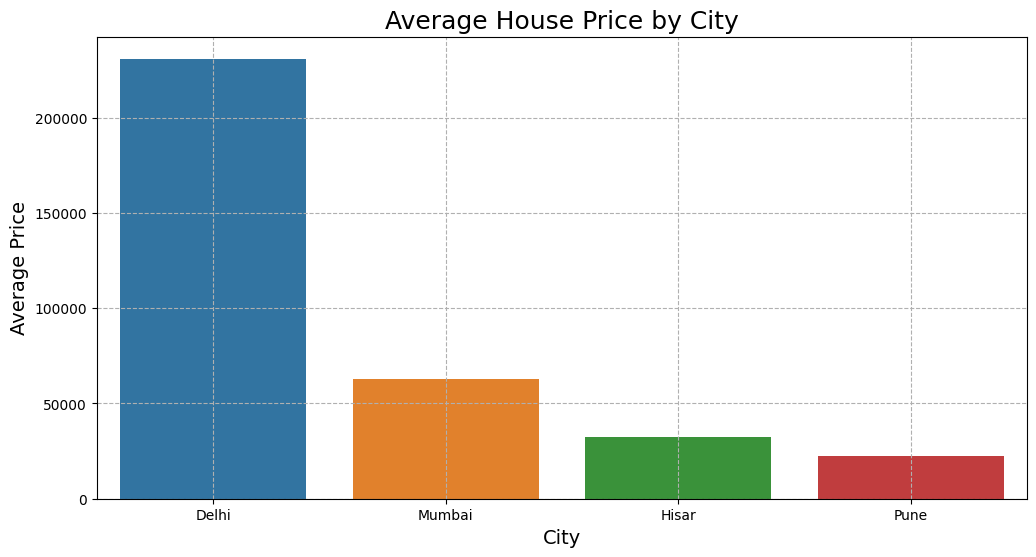

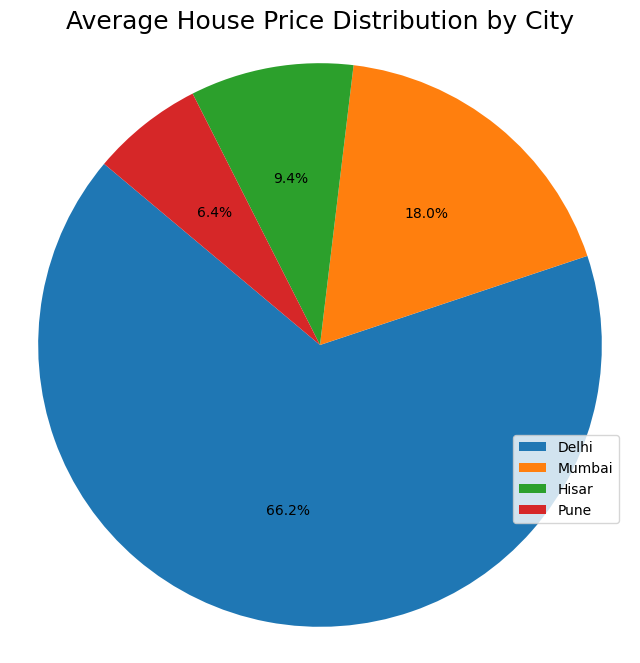

In [22]:
city_price_mean = data_for_EDA.groupby('city')['price'].mean().sort_values(ascending=False)
city_price_mean_df = city_price_mean.reset_index()

# Average House Price by City (Barplot)
plt.figure(figsize=(12,6))  
sns.barplot(x='city', y='price', data=city_price_mean_df)
plt.title('Average House Price by City', fontsize=18)
plt.xlabel('City', fontsize=14)  
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

# Average House Price Distribution by City (Pie plot)
city_names = city_price_mean_df['city']
average_prices = city_price_mean_df['price']
plt.figure(figsize=(8, 8))
plt.pie(average_prices,autopct='%1.1f%%', startangle=140)
plt.title('Average House Price Distribution by City', fontsize=18)  
plt.axis('equal')  
plt.legend(loc='lower left', bbox_to_anchor=(0.8, 0.2),labels=city_names)  
plt.show()

> # House Price Distribution by House Type

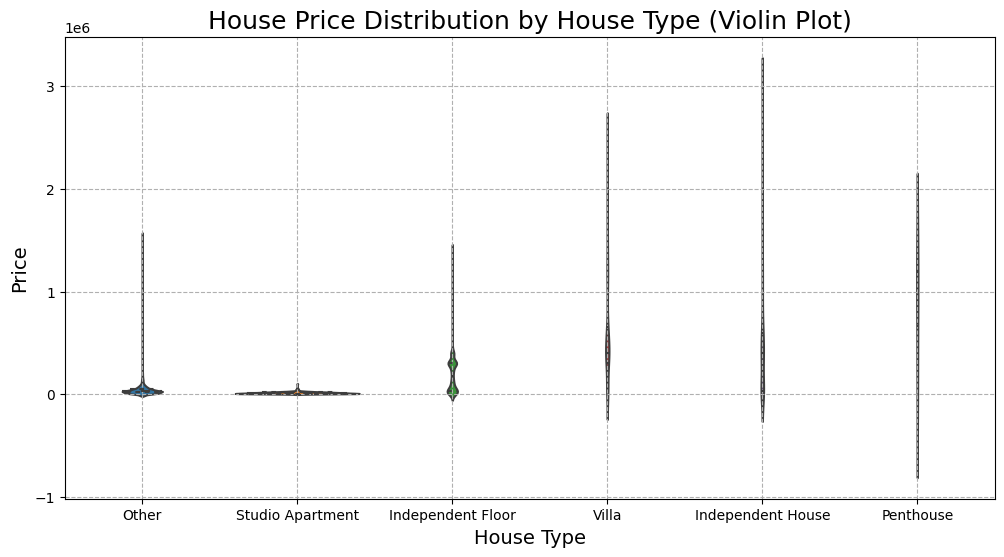

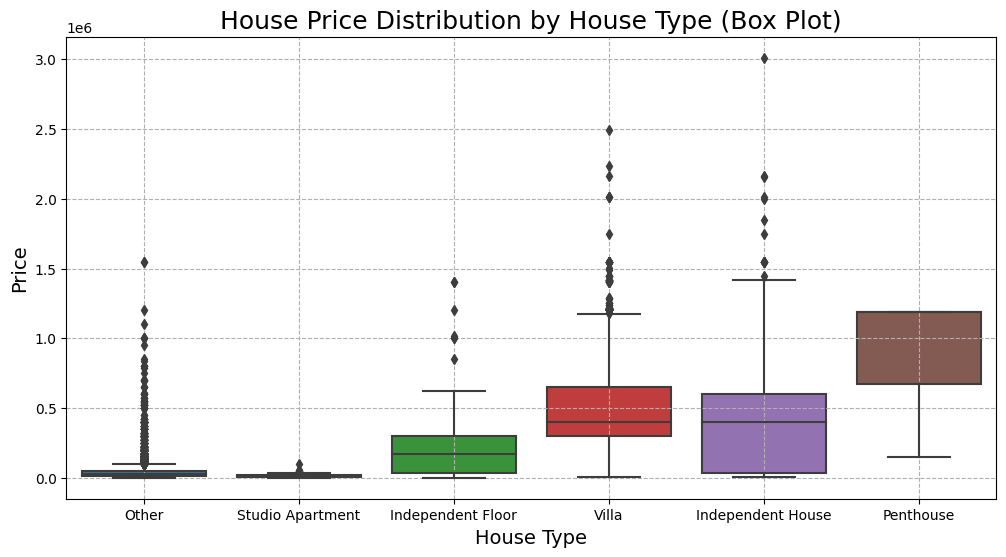

In [23]:
# House Price Distribution by House Type (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='normalize_house_type', y='price', data=data_for_EDA, inner='quartile')
plt.title('House Price Distribution by House Type (Violin Plot)',fontsize=18)
plt.xlabel('House Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

# House Price Distribution by House Type (Box Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='normalize_house_type', y='price', data=data_for_EDA)
plt.title('House Price Distribution by House Type (Box Plot)', fontsize=18)
plt.xlabel('House Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

> # Average House Price by House Type

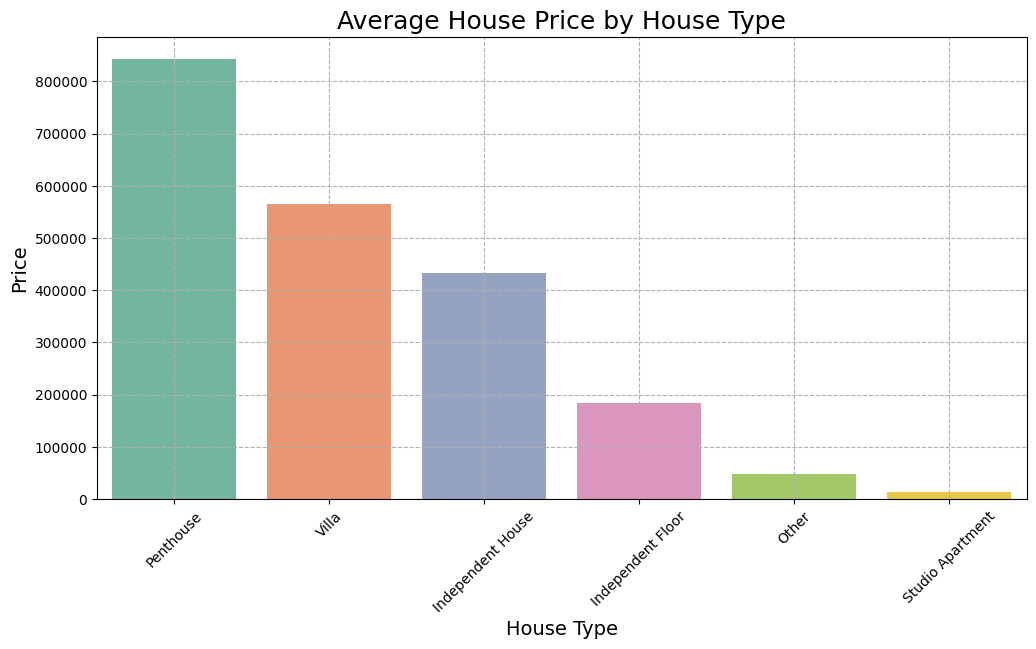

In [24]:
house_type_price_mean = data_for_EDA.groupby('normalize_house_type')['price'].mean().sort_values(ascending=False)
house_type_price_mean_df = house_type_price_mean.reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='normalize_house_type', y='price', data=house_type_price_mean_df, palette='Set2')
plt.title('Average House Price by House Type', fontsize=18)
plt.xlabel('House Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=45, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

> # Average House Price by House Size (Bar Plot) _ Round dowun to 1000 ft.

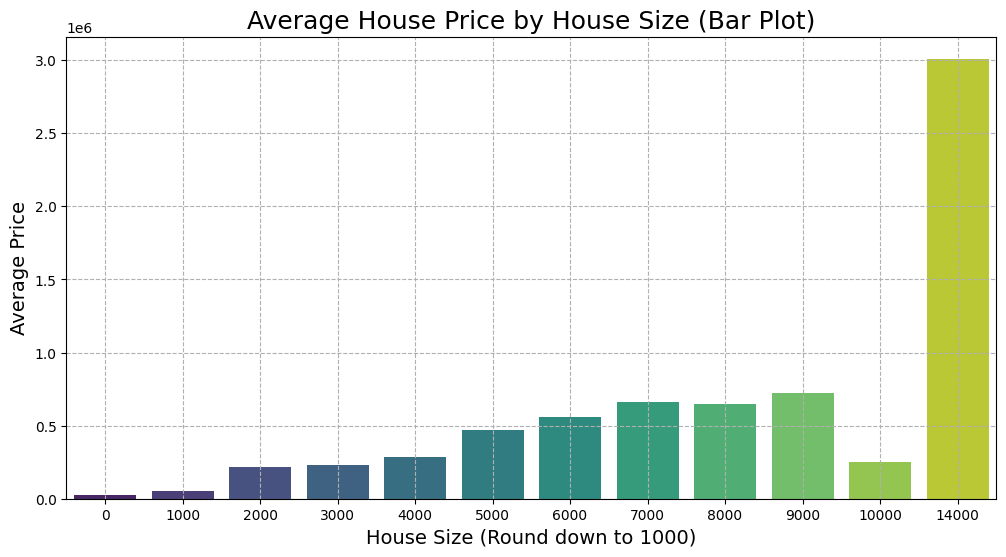

In [25]:
plt.figure(figsize=(12, 6))
sns.barplot(x=house_size_price_mean.index, y=house_size_price_mean.values, palette='viridis')
plt.title('Average House Price by House Size (Bar Plot)', fontsize=18)
plt.xlabel('House Size (Round down to 1000)', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

> # House Size vs Price (Scatter Plot)

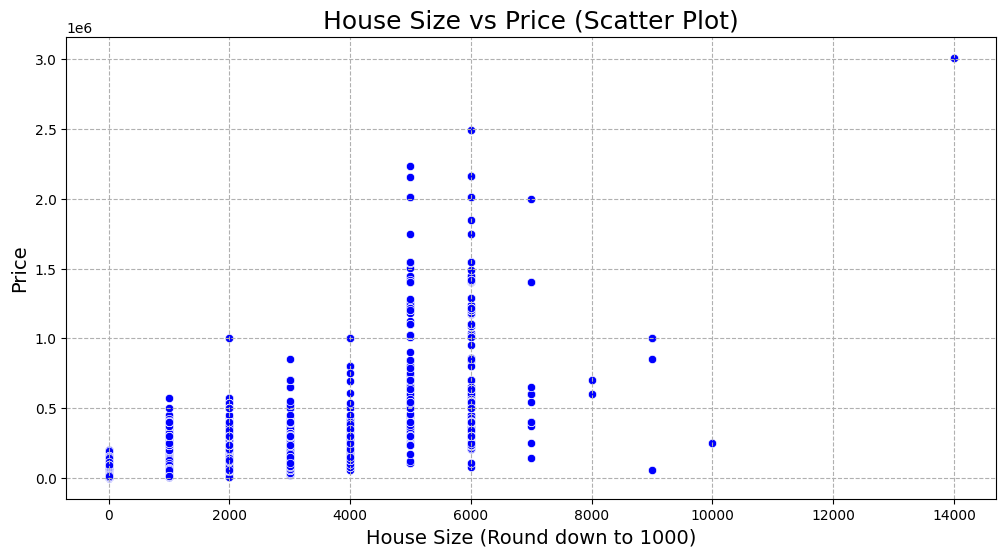

In [26]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='house_size_1000', y='price', data=data_for_EDA, color='blue')
plt.title('House Size vs Price (Scatter Plot)', fontsize=18)
plt.xlabel('House Size (Round down to 1000)', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)  
plt.yticks(fontsize=10)  
plt.grid(linestyle='--') 
plt.show()

> # House Prices by Location

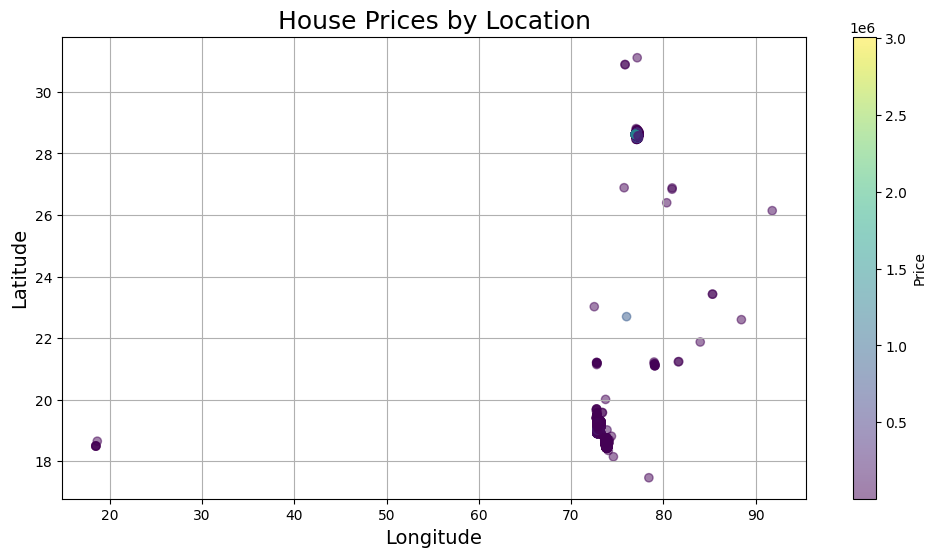

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(data_for_EDA['longitude'], data_for_EDA['latitude'], c=data_for_EDA['price'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Price')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('House Prices by Location', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid('--')
plt.show()

> # Average House Price by Number of Bathrooms

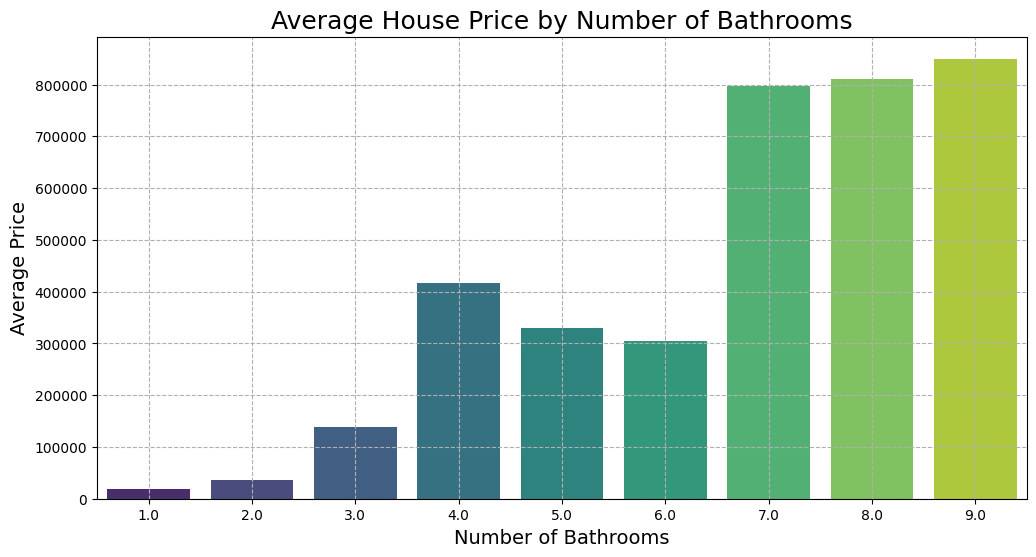

In [28]:
bathroom_price_mean = data_for_EDA.groupby('numBathrooms')['price'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=bathroom_price_mean.index, y=bathroom_price_mean.values, palette='viridis')
plt.title('Average House Price by Number of Bathrooms', fontsize=18)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()

> # House Price by Negotiability

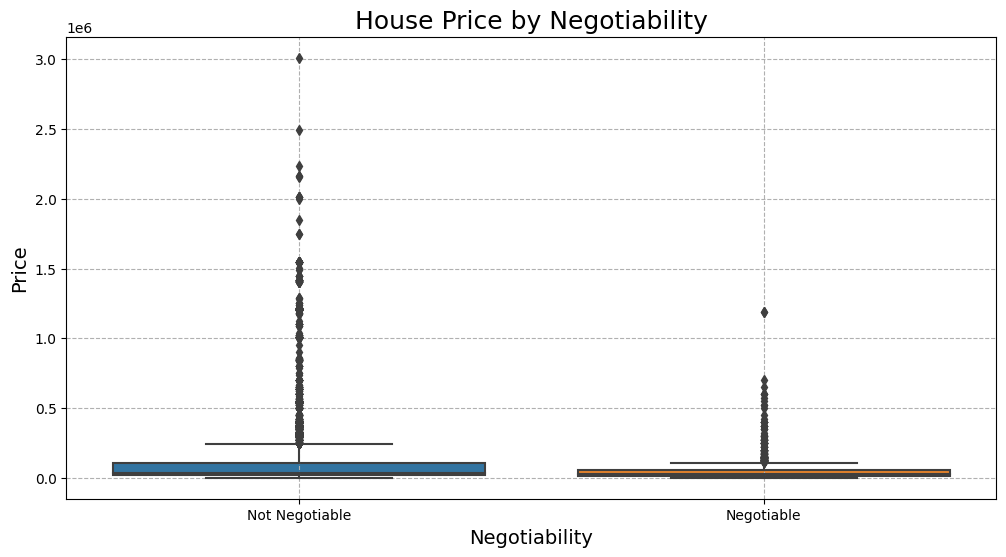

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='isNegotiable', y='price', data=data_for_EDA)
plt.title('House Price by Negotiability', fontsize=18)
plt.xlabel('Negotiability', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Not Negotiable', 'Negotiable'], fontsize=10)  
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()

> # House Distribution by Status

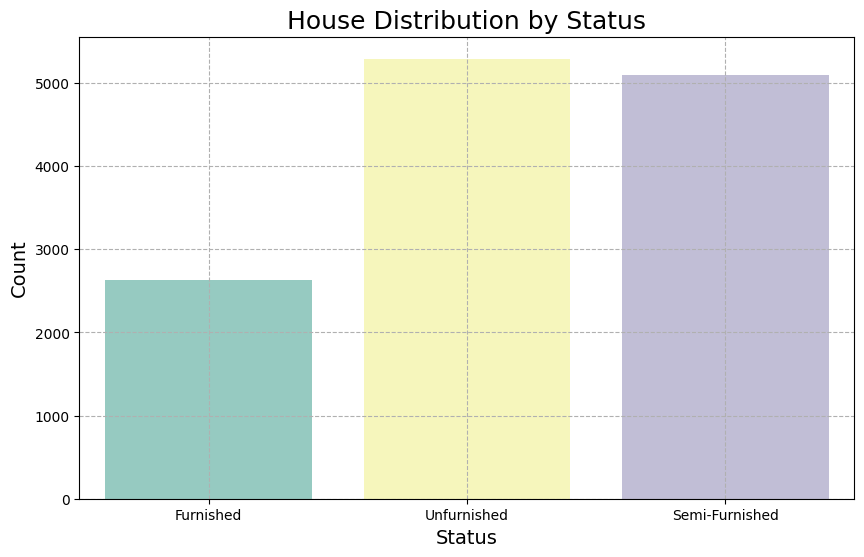

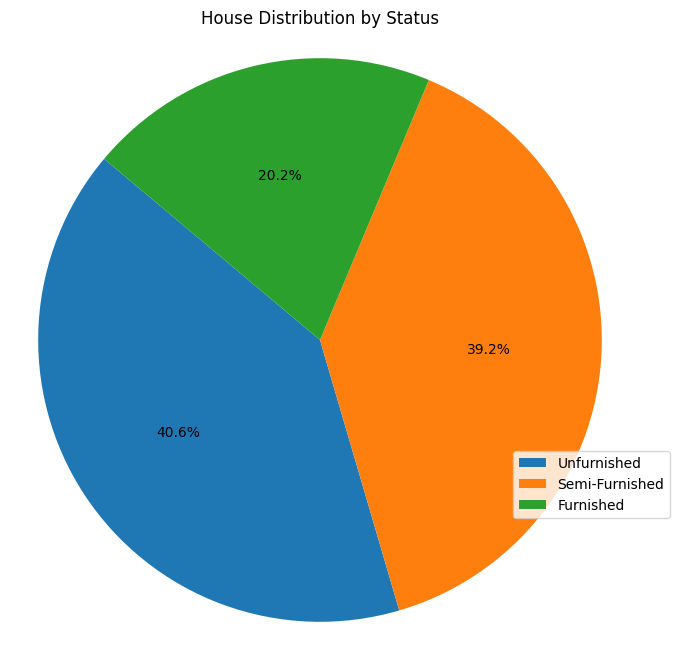

In [30]:
# House Distribution by Status (Countplot)
plt.figure(figsize=(10, 6))
sns.countplot(x='Status', data=data_for_EDA, palette='Set3')
plt.title('House Distribution by Status', fontsize=18)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()

# House Distribution by Status (Pie plot)
status_counts = data_for_EDA['Status'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, autopct='%1.1f%%', startangle=140)
plt.title('House Distribution by Status')
plt.axis('equal')
plt.legend(loc='lower left', bbox_to_anchor=(0.8, 0.2),labels=status_counts.index)  
plt.show()

> # Distribution of Date Types

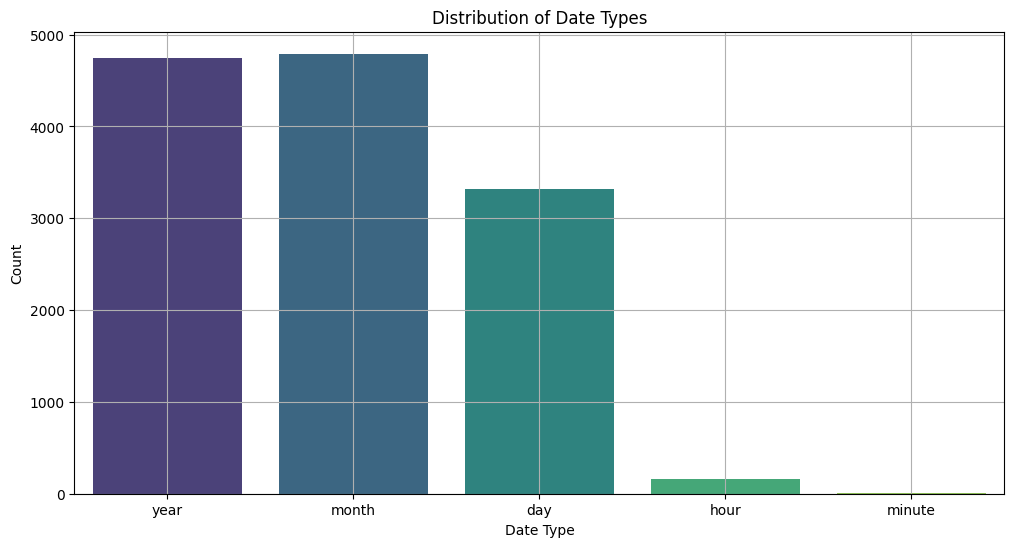

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(x='date_type', data=data_for_EDA, palette='viridis')
plt.title('Distribution of Date Types')
plt.xlabel('Date Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid('--')
plt.show()

# Model : Predict the House price (Regressor Model)

In [32]:
# Define features and target variable
X = data_for_model.drop(columns=['price'])
y = data_for_model['price']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

feature_selector = SelectFromModel(RandomForestRegressor())

# Define the pipeline including feature selector and model
pipeline = Pipeline([
    ('feature_selector', feature_selector),
    ('regressor', RandomForestRegressor())
])

pipeline.fit(X_train_df, y_train)

X_train_selected = pipeline.named_steps['feature_selector'].transform(X_train_df)
X_test_selected = pipeline.named_steps['feature_selector'].transform(X_test_df)

selected_feature_indices = pipeline.named_steps['feature_selector'].get_support(indices=True)
selected_features = X_train_df.columns[selected_feature_indices]

print("Selected features:",selected_features)

Selected features: Index(['location_Central Ridge Reserve Forest', 'location_DLF Farms',
       'normalize_house_type_Independent Floor', 'house_size', 'latitude',
       'longitude', 'numBathrooms', 'SecurityDeposit'],
      dtype='object')


In [33]:
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)

In [34]:
linear_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

xgb_pipeline = Pipeline([
    ('regressor', XGBRegressor())
])

cart_pipeline = Pipeline([
    ('regressor', DecisionTreeRegressor())
])

rf_pipeline = Pipeline([
    ('regressor', RandomForestRegressor())
])

lgbm_pipeline = Pipeline([
    ('regressor', LGBMRegressor())
])

gb_pipeline = Pipeline([
    ('regressor', GradientBoostingRegressor())
])

results = []

for pipeline in [linear_pipeline, xgb_pipeline,cart_pipeline, rf_pipeline, lgbm_pipeline, gb_pipeline]:
    pipeline.fit(X_train_selected_df, y_train)
    y_pred = pipeline.predict(X_test_selected_df)
    mse = mean_squared_error(y_test, y_pred)

    results.append({
        "Model": pipeline.named_steps['regressor'].__class__.__name__,
        "RMSE": mse**0.5
    })

results_df = pd.DataFrame(results)
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 10419, number of used features: 6
[LightGBM] [Info] Start training from score 112792.609463


,Model,RMSE
0,LinearRegression,72935.747305
1,XGBRegressor,43504.364745
2,DecisionTreeRegressor,43278.291162
3,RandomForestRegressor,35213.162599
4,LGBMRegressor,39207.766326
5,GradientBoostingRegressor,41793.600977


In [35]:
min_rmse_model = results_df[results_df['RMSE'] == results_df['RMSE'].min()]
print('Model (BEST RMSE) :', min_rmse_model['Model'].values[0])

Model (BEST RMSE) : RandomForestRegressor


> # Evaluating RandomForestRegressor

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

model = RandomForestRegressor(random_state=100)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=100)

In [37]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print('train_RMSE :',round(mean_squared_error(y_train,train_pred)**0.5,2))
print('test_RMSE :',round(mean_squared_error(y_test,test_pred)**0.5))

train_RMSE : 14283.25
test_RMSE : 48624


In [38]:
comparison = pd.DataFrame({'actual': y_test, 'pred': test_pred})
comparison

,actual,pred
1232,50000,44994.510823
11478,301022,326736.670000
6357,30000,29960.000000
1471,27000,27300.000000
3367,47000,56070.000000
...,...,...
7952,20000,22893.333333
5005,15500,14404.216765
7557,20000,20850.000000
8137,12000,12884.000000


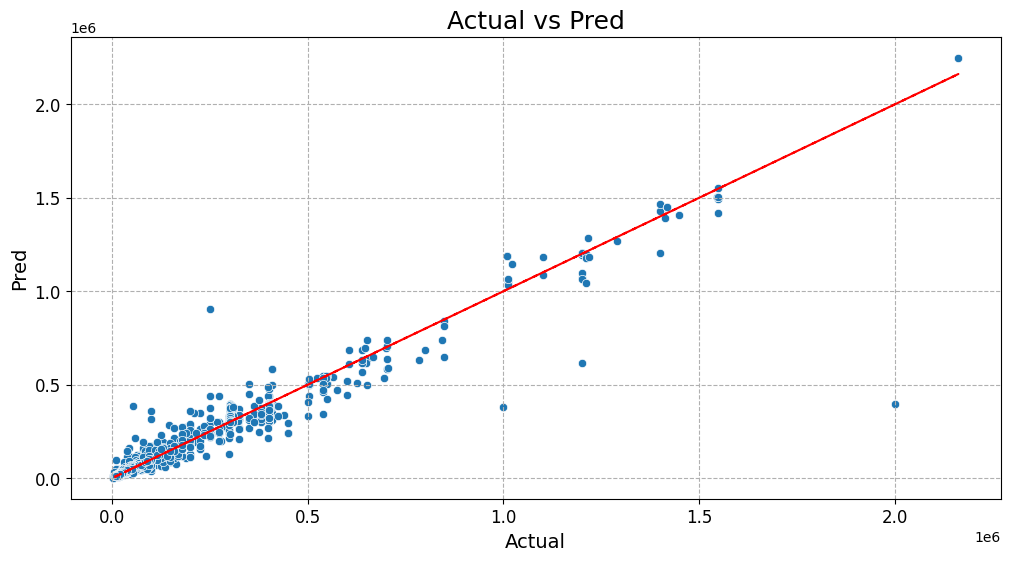

In [39]:
plt.figure(figsize=(12,6))

sns.scatterplot(x='actual', y='pred', data=comparison)
plt.plot(comparison['actual'], comparison['actual'], color='red', linestyle='--')
plt.title('Actual vs Pred', fontsize=18)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Pred', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.show()

> # Feature Importance

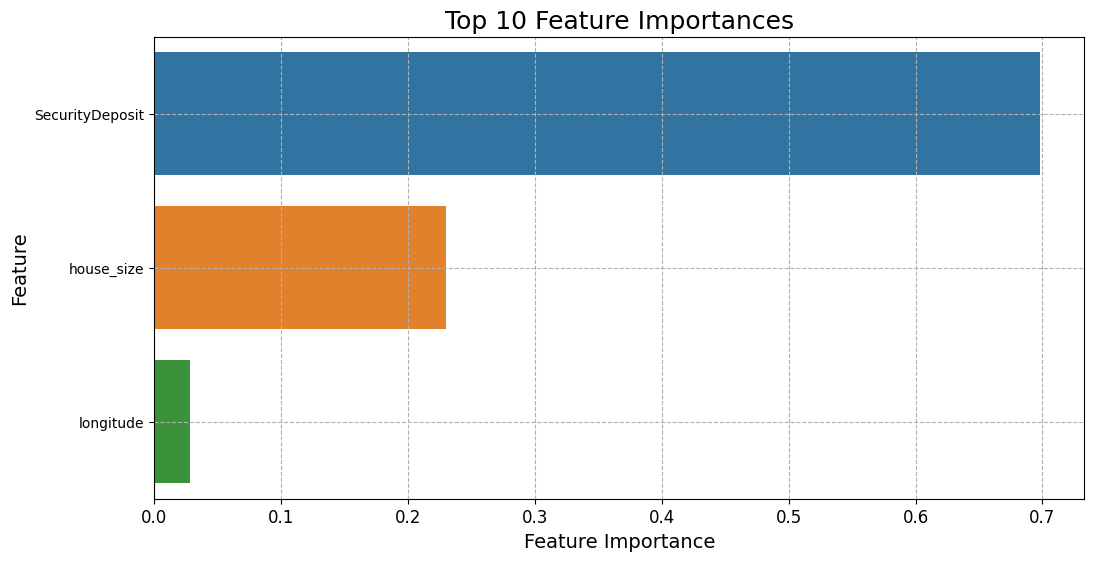

In [40]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = X_train.columns
top_indices = indices[:3]
top_importances = importances[top_indices]
top_feature_names = np.array(feature_names)[top_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_importances, y=top_feature_names)
plt.title('Top 10 Feature Importances', fontsize=18)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  
plt.yticks(fontsize=10)
plt.grid(linestyle='--')
plt.show()

# Thanks

### Further feature engineering and a Hyperparameter optimization of the model will lead to better predictions (I'm going to proceed if someone asks...)